In [1]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Constants
GAMMA = 0.9

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
        return highest_prob_action, log_prob

In [3]:
def update_policy(policy_network, rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [6]:
def main():
    env = gym.make('CartPole-v0')
    policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)
    
    max_episode_num = 5000
    max_steps = 10000
    numsteps = []
    avg_numsteps = []
    all_rewards = []

    for episode in range(max_episode_num):
        state = env.reset()
        log_probs = []
        rewards = []

        for steps in range(max_steps):
            env.render()
            action, log_prob = policy_net.get_action(state)
            new_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                update_policy(policy_net, rewards, log_probs)
                numsteps.append(steps)
                avg_numsteps.append(np.mean(numsteps[-10:]))
                all_rewards.append(np.sum(rewards))
                if episode % 1 == 0:
                    sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
                break
            
            state = new_state
        
    plt.plot(numsteps)
    plt.plot(avg_numsteps)
    plt.xlabel('Episode')
    plt.show()
    
    return policy_net, all_rewards

episode: 0, total reward: 12.0, average_reward: 12.0, length: 11
episode: 1, total reward: 24.0, average_reward: 18.0, length: 23
episode: 2, total reward: 34.0, average_reward: 23.333, length: 33
episode: 3, total reward: 39.0, average_reward: 27.25, length: 38
episode: 4, total reward: 62.0, average_reward: 34.2, length: 61
episode: 5, total reward: 12.0, average_reward: 30.5, length: 11
episode: 6, total reward: 29.0, average_reward: 30.286, length: 28
episode: 7, total reward: 18.0, average_reward: 28.75, length: 17
episode: 8, total reward: 19.0, average_reward: 27.667, length: 18
episode: 9, total reward: 18.0, average_reward: 26.7, length: 17
episode: 10, total reward: 16.0, average_reward: 27.1, length: 15
episode: 11, total reward: 39.0, average_reward: 28.6, length: 38
episode: 12, total reward: 40.0, average_reward: 29.2, length: 39
episode: 13, total reward: 18.0, average_reward: 27.1, length: 17
episode: 14, total reward: 14.0, average_reward: 22.3, length: 13
episode: 15,

episode: 124, total reward: 63.0, average_reward: 28.2, length: 62
episode: 125, total reward: 24.0, average_reward: 29.0, length: 23
episode: 126, total reward: 16.0, average_reward: 27.3, length: 15
episode: 127, total reward: 20.0, average_reward: 25.2, length: 19
episode: 128, total reward: 26.0, average_reward: 26.7, length: 25
episode: 129, total reward: 24.0, average_reward: 28.1, length: 23
episode: 130, total reward: 37.0, average_reward: 29.3, length: 36
episode: 131, total reward: 63.0, average_reward: 31.9, length: 62
episode: 132, total reward: 18.0, average_reward: 30.7, length: 17
episode: 133, total reward: 34.0, average_reward: 32.5, length: 33
episode: 134, total reward: 34.0, average_reward: 29.6, length: 33
episode: 135, total reward: 22.0, average_reward: 29.4, length: 21
episode: 136, total reward: 33.0, average_reward: 31.1, length: 32
episode: 137, total reward: 28.0, average_reward: 31.9, length: 27
episode: 138, total reward: 46.0, average_reward: 33.9, length

episode: 251, total reward: 21.0, average_reward: 34.2, length: 20
episode: 252, total reward: 19.0, average_reward: 34.1, length: 18
episode: 253, total reward: 15.0, average_reward: 28.5, length: 14
episode: 254, total reward: 80.0, average_reward: 34.1, length: 79
episode: 255, total reward: 16.0, average_reward: 31.6, length: 15
episode: 256, total reward: 23.0, average_reward: 31.1, length: 22
episode: 257, total reward: 64.0, average_reward: 35.8, length: 63
episode: 258, total reward: 108.0, average_reward: 44.9, length: 107
episode: 259, total reward: 64.0, average_reward: 46.8, length: 63
episode: 260, total reward: 32.0, average_reward: 44.2, length: 31
episode: 261, total reward: 61.0, average_reward: 48.2, length: 60
episode: 262, total reward: 28.0, average_reward: 49.1, length: 27
episode: 263, total reward: 67.0, average_reward: 54.3, length: 66
episode: 264, total reward: 31.0, average_reward: 49.4, length: 30
episode: 265, total reward: 27.0, average_reward: 50.5, leng

episode: 377, total reward: 48.0, average_reward: 52.5, length: 47
episode: 378, total reward: 44.0, average_reward: 48.3, length: 43
episode: 379, total reward: 77.0, average_reward: 53.3, length: 76
episode: 380, total reward: 29.0, average_reward: 53.3, length: 28
episode: 381, total reward: 99.0, average_reward: 61.4, length: 98
episode: 382, total reward: 151.0, average_reward: 68.1, length: 150
episode: 383, total reward: 20.0, average_reward: 67.4, length: 19
episode: 384, total reward: 62.0, average_reward: 60.6, length: 61
episode: 385, total reward: 115.0, average_reward: 67.2, length: 114
episode: 386, total reward: 31.0, average_reward: 67.6, length: 30
episode: 387, total reward: 42.0, average_reward: 67.0, length: 41
episode: 388, total reward: 91.0, average_reward: 71.7, length: 90
episode: 389, total reward: 42.0, average_reward: 68.2, length: 41
episode: 390, total reward: 60.0, average_reward: 71.3, length: 59
episode: 391, total reward: 28.0, average_reward: 64.2, le

episode: 499, total reward: 139.0, average_reward: 106.6, length: 138
episode: 500, total reward: 39.0, average_reward: 107.2, length: 38
episode: 501, total reward: 160.0, average_reward: 105.9, length: 159
episode: 502, total reward: 91.0, average_reward: 108.2, length: 90
episode: 503, total reward: 177.0, average_reward: 116.4, length: 176
episode: 504, total reward: 49.0, average_reward: 101.4, length: 48
episode: 505, total reward: 56.0, average_reward: 96.0, length: 55
episode: 506, total reward: 20.0, average_reward: 81.6, length: 19
episode: 507, total reward: 170.0, average_reward: 92.2, length: 169
episode: 508, total reward: 99.0, average_reward: 100.0, length: 98
episode: 509, total reward: 82.0, average_reward: 94.3, length: 81
episode: 510, total reward: 33.0, average_reward: 93.7, length: 32
episode: 511, total reward: 159.0, average_reward: 93.6, length: 158
episode: 512, total reward: 80.0, average_reward: 92.5, length: 79
episode: 513, total reward: 78.0, average_rew

episode: 621, total reward: 75.0, average_reward: 106.9, length: 74
episode: 622, total reward: 128.0, average_reward: 112.4, length: 127
episode: 623, total reward: 44.0, average_reward: 101.1, length: 43
episode: 624, total reward: 71.0, average_reward: 93.0, length: 70
episode: 625, total reward: 110.0, average_reward: 101.5, length: 109
episode: 626, total reward: 28.0, average_reward: 84.3, length: 27
episode: 627, total reward: 92.0, average_reward: 80.4, length: 91
episode: 628, total reward: 39.0, average_reward: 74.7, length: 38
episode: 629, total reward: 120.0, average_reward: 79.3, length: 119
episode: 630, total reward: 121.0, average_reward: 82.8, length: 120
episode: 631, total reward: 36.0, average_reward: 78.9, length: 35
episode: 632, total reward: 199.0, average_reward: 86.0, length: 198
episode: 633, total reward: 120.0, average_reward: 93.6, length: 119
episode: 634, total reward: 73.0, average_reward: 93.8, length: 72
episode: 635, total reward: 62.0, average_rewa

episode: 742, total reward: 200.0, average_reward: 118.3, length: 199
episode: 743, total reward: 147.0, average_reward: 124.3, length: 146
episode: 744, total reward: 123.0, average_reward: 125.2, length: 122
episode: 745, total reward: 110.0, average_reward: 122.1, length: 109
episode: 746, total reward: 97.0, average_reward: 119.7, length: 96
episode: 747, total reward: 139.0, average_reward: 127.1, length: 138
episode: 748, total reward: 102.0, average_reward: 133.0, length: 101
episode: 749, total reward: 197.0, average_reward: 137.5, length: 196
episode: 750, total reward: 200.0, average_reward: 143.4, length: 199
episode: 751, total reward: 200.0, average_reward: 151.5, length: 199
episode: 752, total reward: 111.0, average_reward: 142.6, length: 110
episode: 753, total reward: 171.0, average_reward: 145.0, length: 170
episode: 754, total reward: 114.0, average_reward: 144.1, length: 113
episode: 755, total reward: 152.0, average_reward: 148.3, length: 151
episode: 756, total re

episode: 860, total reward: 200.0, average_reward: 173.0, length: 199
episode: 861, total reward: 195.0, average_reward: 181.5, length: 194
episode: 862, total reward: 200.0, average_reward: 181.5, length: 199
episode: 863, total reward: 200.0, average_reward: 185.5, length: 199
episode: 864, total reward: 134.0, average_reward: 178.9, length: 133
episode: 865, total reward: 187.0, average_reward: 177.6, length: 186
episode: 866, total reward: 200.0, average_reward: 178.6, length: 199
episode: 867, total reward: 197.0, average_reward: 184.6, length: 196
episode: 868, total reward: 86.0, average_reward: 173.2, length: 85
episode: 869, total reward: 200.0, average_reward: 179.9, length: 199
episode: 870, total reward: 156.0, average_reward: 175.5, length: 155
episode: 871, total reward: 200.0, average_reward: 176.0, length: 199
episode: 872, total reward: 172.0, average_reward: 173.2, length: 171
episode: 873, total reward: 68.0, average_reward: 160.0, length: 67
episode: 874, total rewa

episode: 979, total reward: 200.0, average_reward: 150.9, length: 199
episode: 980, total reward: 163.0, average_reward: 147.2, length: 162
episode: 981, total reward: 106.0, average_reward: 144.0, length: 105
episode: 982, total reward: 133.0, average_reward: 145.0, length: 132
episode: 983, total reward: 200.0, average_reward: 156.7, length: 199
episode: 984, total reward: 200.0, average_reward: 156.7, length: 199
episode: 985, total reward: 113.0, average_reward: 154.3, length: 112
episode: 986, total reward: 164.0, average_reward: 166.1, length: 163
episode: 987, total reward: 125.0, average_reward: 160.4, length: 124
episode: 988, total reward: 200.0, average_reward: 160.4, length: 199
episode: 989, total reward: 200.0, average_reward: 160.4, length: 199
episode: 990, total reward: 178.0, average_reward: 161.9, length: 177
episode: 991, total reward: 200.0, average_reward: 171.3, length: 199
episode: 992, total reward: 157.0, average_reward: 173.7, length: 156
episode: 993, total 

episode: 1097, total reward: 200.0, average_reward: 162.7, length: 199
episode: 1098, total reward: 47.0, average_reward: 147.4, length: 46
episode: 1099, total reward: 107.0, average_reward: 145.9, length: 106
episode: 1100, total reward: 158.0, average_reward: 142.5, length: 157
episode: 1101, total reward: 200.0, average_reward: 156.5, length: 199
episode: 1102, total reward: 51.0, average_reward: 141.6, length: 50
episode: 1103, total reward: 197.0, average_reward: 141.3, length: 196
episode: 1104, total reward: 134.0, average_reward: 134.7, length: 133
episode: 1105, total reward: 123.0, average_reward: 127.0, length: 122
episode: 1106, total reward: 200.0, average_reward: 141.7, length: 199
episode: 1107, total reward: 147.0, average_reward: 136.4, length: 146
episode: 1108, total reward: 163.0, average_reward: 148.0, length: 162
episode: 1109, total reward: 200.0, average_reward: 157.3, length: 199
episode: 1110, total reward: 200.0, average_reward: 161.5, length: 199
episode: 1

episode: 1214, total reward: 132.0, average_reward: 192.4, length: 131
episode: 1215, total reward: 200.0, average_reward: 192.4, length: 199
episode: 1216, total reward: 160.0, average_reward: 188.4, length: 159
episode: 1217, total reward: 166.0, average_reward: 185.0, length: 165
episode: 1218, total reward: 200.0, average_reward: 185.0, length: 199
episode: 1219, total reward: 136.0, average_reward: 179.4, length: 135
episode: 1220, total reward: 133.0, average_reward: 172.7, length: 132
episode: 1221, total reward: 200.0, average_reward: 172.7, length: 199
episode: 1222, total reward: 200.0, average_reward: 172.7, length: 199
episode: 1223, total reward: 200.0, average_reward: 172.7, length: 199
episode: 1224, total reward: 200.0, average_reward: 179.5, length: 199
episode: 1225, total reward: 165.0, average_reward: 176.0, length: 164
episode: 1226, total reward: 200.0, average_reward: 180.0, length: 199
episode: 1227, total reward: 178.0, average_reward: 181.2, length: 177
episod

episode: 1330, total reward: 190.0, average_reward: 189.7, length: 189
episode: 1331, total reward: 167.0, average_reward: 186.4, length: 166
episode: 1332, total reward: 200.0, average_reward: 186.4, length: 199
episode: 1333, total reward: 192.0, average_reward: 188.0, length: 191
episode: 1334, total reward: 200.0, average_reward: 188.0, length: 199
episode: 1335, total reward: 174.0, average_reward: 191.0, length: 173
episode: 1336, total reward: 200.0, average_reward: 191.0, length: 199
episode: 1337, total reward: 200.0, average_reward: 191.1, length: 199
episode: 1338, total reward: 79.0, average_reward: 179.0, length: 78
episode: 1339, total reward: 148.0, average_reward: 175.0, length: 147
episode: 1340, total reward: 162.0, average_reward: 172.2, length: 161
episode: 1341, total reward: 182.0, average_reward: 173.7, length: 181
episode: 1342, total reward: 176.0, average_reward: 171.3, length: 175
episode: 1343, total reward: 200.0, average_reward: 172.1, length: 199
episode:

episode: 1447, total reward: 200.0, average_reward: 188.4, length: 199
episode: 1448, total reward: 200.0, average_reward: 188.4, length: 199
episode: 1449, total reward: 200.0, average_reward: 188.4, length: 199
episode: 1450, total reward: 200.0, average_reward: 188.4, length: 199
episode: 1451, total reward: 200.0, average_reward: 191.9, length: 199
episode: 1452, total reward: 200.0, average_reward: 191.9, length: 199
episode: 1453, total reward: 199.0, average_reward: 199.9, length: 198
episode: 1454, total reward: 141.0, average_reward: 194.0, length: 140
episode: 1455, total reward: 188.0, average_reward: 192.8, length: 187
episode: 1456, total reward: 44.0, average_reward: 177.2, length: 43
episode: 1457, total reward: 200.0, average_reward: 177.2, length: 199
episode: 1458, total reward: 200.0, average_reward: 177.2, length: 199
episode: 1459, total reward: 197.0, average_reward: 176.9, length: 196
episode: 1460, total reward: 200.0, average_reward: 176.9, length: 199
episode:

episode: 1563, total reward: 200.0, average_reward: 192.3, length: 199
episode: 1564, total reward: 200.0, average_reward: 192.3, length: 199
episode: 1565, total reward: 200.0, average_reward: 192.3, length: 199
episode: 1566, total reward: 132.0, average_reward: 185.5, length: 131
episode: 1567, total reward: 200.0, average_reward: 189.0, length: 199
episode: 1568, total reward: 186.0, average_reward: 187.6, length: 185
episode: 1569, total reward: 200.0, average_reward: 187.6, length: 199
episode: 1570, total reward: 162.0, average_reward: 186.9, length: 161
episode: 1571, total reward: 200.0, average_reward: 188.0, length: 199
episode: 1572, total reward: 200.0, average_reward: 188.0, length: 199
episode: 1573, total reward: 192.0, average_reward: 187.2, length: 191
episode: 1574, total reward: 200.0, average_reward: 187.2, length: 199
episode: 1575, total reward: 200.0, average_reward: 187.2, length: 199
episode: 1576, total reward: 192.0, average_reward: 193.2, length: 191
episod

episode: 1679, total reward: 180.0, average_reward: 174.1, length: 179
episode: 1680, total reward: 90.0, average_reward: 171.8, length: 89
episode: 1681, total reward: 200.0, average_reward: 175.3, length: 199
episode: 1682, total reward: 139.0, average_reward: 169.2, length: 138
episode: 1683, total reward: 200.0, average_reward: 171.1, length: 199
episode: 1684, total reward: 170.0, average_reward: 175.0, length: 169
episode: 1685, total reward: 148.0, average_reward: 169.8, length: 147
episode: 1686, total reward: 200.0, average_reward: 169.8, length: 199
episode: 1687, total reward: 191.0, average_reward: 168.9, length: 190
episode: 1688, total reward: 200.0, average_reward: 171.8, length: 199
episode: 1689, total reward: 200.0, average_reward: 173.8, length: 199
episode: 1690, total reward: 128.0, average_reward: 177.6, length: 127
episode: 1691, total reward: 124.0, average_reward: 170.0, length: 123
episode: 1692, total reward: 200.0, average_reward: 176.1, length: 199
episode:

episode: 1795, total reward: 121.0, average_reward: 170.0, length: 120
episode: 1796, total reward: 200.0, average_reward: 170.0, length: 199
episode: 1797, total reward: 200.0, average_reward: 170.0, length: 199
episode: 1798, total reward: 103.0, average_reward: 166.8, length: 102
episode: 1799, total reward: 200.0, average_reward: 166.8, length: 199
episode: 1800, total reward: 200.0, average_reward: 166.8, length: 199
episode: 1801, total reward: 186.0, average_reward: 171.6, length: 185
episode: 1802, total reward: 200.0, average_reward: 181.0, length: 199
episode: 1803, total reward: 200.0, average_reward: 181.0, length: 199
episode: 1804, total reward: 200.0, average_reward: 181.0, length: 199
episode: 1805, total reward: 159.0, average_reward: 184.8, length: 158
episode: 1806, total reward: 176.0, average_reward: 182.4, length: 175
episode: 1807, total reward: 200.0, average_reward: 182.4, length: 199
episode: 1808, total reward: 200.0, average_reward: 192.1, length: 199
episod

episode: 1911, total reward: 157.0, average_reward: 176.1, length: 156
episode: 1912, total reward: 200.0, average_reward: 179.0, length: 199
episode: 1913, total reward: 200.0, average_reward: 179.0, length: 199
episode: 1914, total reward: 148.0, average_reward: 173.8, length: 147
episode: 1915, total reward: 187.0, average_reward: 177.7, length: 186
episode: 1916, total reward: 200.0, average_reward: 189.2, length: 199
episode: 1917, total reward: 200.0, average_reward: 189.2, length: 199
episode: 1918, total reward: 186.0, average_reward: 187.8, length: 185
episode: 1919, total reward: 200.0, average_reward: 187.8, length: 199
episode: 1920, total reward: 200.0, average_reward: 187.8, length: 199
episode: 1921, total reward: 200.0, average_reward: 192.1, length: 199
episode: 1922, total reward: 200.0, average_reward: 192.1, length: 199
episode: 1923, total reward: 150.0, average_reward: 187.1, length: 149
episode: 1924, total reward: 200.0, average_reward: 192.3, length: 199
episod

episode: 2027, total reward: 200.0, average_reward: 181.1, length: 199
episode: 2028, total reward: 200.0, average_reward: 181.1, length: 199
episode: 2029, total reward: 182.0, average_reward: 185.7, length: 181
episode: 2030, total reward: 200.0, average_reward: 185.7, length: 199
episode: 2031, total reward: 200.0, average_reward: 192.2, length: 199
episode: 2032, total reward: 200.0, average_reward: 192.6, length: 199
episode: 2033, total reward: 200.0, average_reward: 198.2, length: 199
episode: 2034, total reward: 200.0, average_reward: 198.2, length: 199
episode: 2035, total reward: 191.0, average_reward: 197.3, length: 190
episode: 2036, total reward: 200.0, average_reward: 197.3, length: 199
episode: 2037, total reward: 200.0, average_reward: 197.3, length: 199
episode: 2038, total reward: 154.0, average_reward: 192.7, length: 153
episode: 2039, total reward: 200.0, average_reward: 194.5, length: 199
episode: 2040, total reward: 200.0, average_reward: 194.5, length: 199
episod

episode: 2143, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2144, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2145, total reward: 145.0, average_reward: 194.5, length: 144
episode: 2146, total reward: 200.0, average_reward: 194.5, length: 199
episode: 2147, total reward: 200.0, average_reward: 194.5, length: 199
episode: 2148, total reward: 200.0, average_reward: 194.5, length: 199
episode: 2149, total reward: 200.0, average_reward: 194.5, length: 199
episode: 2150, total reward: 200.0, average_reward: 194.5, length: 199
episode: 2151, total reward: 200.0, average_reward: 194.5, length: 199
episode: 2152, total reward: 200.0, average_reward: 194.5, length: 199
episode: 2153, total reward: 199.0, average_reward: 194.4, length: 198
episode: 2154, total reward: 200.0, average_reward: 194.4, length: 199
episode: 2155, total reward: 183.0, average_reward: 198.2, length: 182
episode: 2156, total reward: 200.0, average_reward: 198.2, length: 199
episod

episode: 2260, total reward: 200.0, average_reward: 197.5, length: 199
episode: 2261, total reward: 200.0, average_reward: 199.1, length: 199
episode: 2262, total reward: 200.0, average_reward: 199.1, length: 199
episode: 2263, total reward: 171.0, average_reward: 196.2, length: 170
episode: 2264, total reward: 200.0, average_reward: 196.2, length: 199
episode: 2265, total reward: 200.0, average_reward: 196.2, length: 199
episode: 2266, total reward: 200.0, average_reward: 196.2, length: 199
episode: 2267, total reward: 200.0, average_reward: 196.2, length: 199
episode: 2268, total reward: 200.0, average_reward: 197.1, length: 199
episode: 2269, total reward: 176.0, average_reward: 194.7, length: 175
episode: 2270, total reward: 200.0, average_reward: 194.7, length: 199
episode: 2271, total reward: 200.0, average_reward: 194.7, length: 199
episode: 2272, total reward: 200.0, average_reward: 194.7, length: 199
episode: 2273, total reward: 145.0, average_reward: 192.1, length: 144
episod

episode: 2376, total reward: 200.0, average_reward: 169.7, length: 199
episode: 2377, total reward: 200.0, average_reward: 169.7, length: 199
episode: 2378, total reward: 128.0, average_reward: 176.3, length: 127
episode: 2379, total reward: 200.0, average_reward: 179.2, length: 199
episode: 2380, total reward: 200.0, average_reward: 179.2, length: 199
episode: 2381, total reward: 200.0, average_reward: 179.2, length: 199
episode: 2382, total reward: 200.0, average_reward: 179.2, length: 199
episode: 2383, total reward: 200.0, average_reward: 179.2, length: 199
episode: 2384, total reward: 200.0, average_reward: 187.4, length: 199
episode: 2385, total reward: 184.0, average_reward: 191.2, length: 183
episode: 2386, total reward: 200.0, average_reward: 191.2, length: 199
episode: 2387, total reward: 189.0, average_reward: 190.1, length: 188
episode: 2388, total reward: 138.0, average_reward: 191.1, length: 137
episode: 2389, total reward: 200.0, average_reward: 191.1, length: 199
episod

episode: 2492, total reward: 200.0, average_reward: 188.6, length: 199
episode: 2493, total reward: 134.0, average_reward: 182.0, length: 133
episode: 2494, total reward: 200.0, average_reward: 182.5, length: 199
episode: 2495, total reward: 200.0, average_reward: 190.9, length: 199
episode: 2496, total reward: 200.0, average_reward: 193.4, length: 199
episode: 2497, total reward: 200.0, average_reward: 193.4, length: 199
episode: 2498, total reward: 200.0, average_reward: 193.4, length: 199
episode: 2499, total reward: 200.0, average_reward: 193.4, length: 199
episode: 2500, total reward: 200.0, average_reward: 193.4, length: 199
episode: 2501, total reward: 200.0, average_reward: 193.4, length: 199
episode: 2502, total reward: 186.0, average_reward: 192.0, length: 185
episode: 2503, total reward: 200.0, average_reward: 198.6, length: 199
episode: 2504, total reward: 55.0, average_reward: 184.1, length: 54
episode: 2505, total reward: 194.0, average_reward: 183.5, length: 193
episode:

episode: 2608, total reward: 200.0, average_reward: 177.4, length: 199
episode: 2609, total reward: 185.0, average_reward: 175.9, length: 184
episode: 2610, total reward: 200.0, average_reward: 178.6, length: 199
episode: 2611, total reward: 200.0, average_reward: 181.3, length: 199
episode: 2612, total reward: 200.0, average_reward: 184.8, length: 199
episode: 2613, total reward: 200.0, average_reward: 188.1, length: 199
episode: 2614, total reward: 156.0, average_reward: 192.5, length: 155
episode: 2615, total reward: 200.0, average_reward: 194.1, length: 199
episode: 2616, total reward: 179.0, average_reward: 192.0, length: 178
episode: 2617, total reward: 200.0, average_reward: 192.0, length: 199
episode: 2618, total reward: 173.0, average_reward: 189.3, length: 172
episode: 2619, total reward: 200.0, average_reward: 190.8, length: 199
episode: 2620, total reward: 200.0, average_reward: 190.8, length: 199
episode: 2621, total reward: 143.0, average_reward: 185.1, length: 142
episod

episode: 2724, total reward: 200.0, average_reward: 174.4, length: 199
episode: 2725, total reward: 200.0, average_reward: 174.4, length: 199
episode: 2726, total reward: 200.0, average_reward: 181.3, length: 199
episode: 2727, total reward: 196.0, average_reward: 180.9, length: 195
episode: 2728, total reward: 153.0, average_reward: 180.8, length: 152
episode: 2729, total reward: 200.0, average_reward: 180.8, length: 199
episode: 2730, total reward: 200.0, average_reward: 186.9, length: 199
episode: 2731, total reward: 176.0, average_reward: 192.5, length: 175
episode: 2732, total reward: 200.0, average_reward: 192.5, length: 199
episode: 2733, total reward: 200.0, average_reward: 192.5, length: 199
episode: 2734, total reward: 200.0, average_reward: 192.5, length: 199
episode: 2735, total reward: 200.0, average_reward: 192.5, length: 199
episode: 2736, total reward: 200.0, average_reward: 192.5, length: 199
episode: 2737, total reward: 200.0, average_reward: 192.9, length: 199
episod

episode: 2841, total reward: 200.0, average_reward: 197.7, length: 199
episode: 2842, total reward: 200.0, average_reward: 197.9, length: 199
episode: 2843, total reward: 159.0, average_reward: 193.8, length: 158
episode: 2844, total reward: 200.0, average_reward: 193.8, length: 199
episode: 2845, total reward: 200.0, average_reward: 193.8, length: 199
episode: 2846, total reward: 200.0, average_reward: 193.8, length: 199
episode: 2847, total reward: 200.0, average_reward: 193.8, length: 199
episode: 2848, total reward: 200.0, average_reward: 193.8, length: 199
episode: 2849, total reward: 158.0, average_reward: 191.7, length: 157
episode: 2850, total reward: 200.0, average_reward: 191.7, length: 199
episode: 2851, total reward: 191.0, average_reward: 190.8, length: 190
episode: 2852, total reward: 200.0, average_reward: 190.8, length: 199
episode: 2853, total reward: 200.0, average_reward: 194.9, length: 199
episode: 2854, total reward: 89.0, average_reward: 183.8, length: 88
episode:

episode: 2957, total reward: 200.0, average_reward: 193.4, length: 199
episode: 2958, total reward: 196.0, average_reward: 193.0, length: 195
episode: 2959, total reward: 200.0, average_reward: 193.0, length: 199
episode: 2960, total reward: 200.0, average_reward: 197.5, length: 199
episode: 2961, total reward: 200.0, average_reward: 197.5, length: 199
episode: 2962, total reward: 200.0, average_reward: 197.5, length: 199
episode: 2963, total reward: 200.0, average_reward: 197.5, length: 199
episode: 2964, total reward: 200.0, average_reward: 197.5, length: 199
episode: 2965, total reward: 200.0, average_reward: 199.6, length: 199
episode: 2966, total reward: 200.0, average_reward: 199.6, length: 199
episode: 2967, total reward: 200.0, average_reward: 199.6, length: 199
episode: 2968, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2969, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2970, total reward: 200.0, average_reward: 200.0, length: 199
episod

episode: 3073, total reward: 109.0, average_reward: 162.5, length: 108
episode: 3074, total reward: 200.0, average_reward: 165.7, length: 199
episode: 3075, total reward: 174.0, average_reward: 163.1, length: 173
episode: 3076, total reward: 200.0, average_reward: 163.1, length: 199
episode: 3077, total reward: 157.0, average_reward: 158.8, length: 156
episode: 3078, total reward: 186.0, average_reward: 160.8, length: 185
episode: 3079, total reward: 178.0, average_reward: 170.9, length: 177
episode: 3080, total reward: 106.0, average_reward: 168.9, length: 105
episode: 3081, total reward: 196.0, average_reward: 170.6, length: 195
episode: 3082, total reward: 200.0, average_reward: 170.6, length: 199
episode: 3083, total reward: 156.0, average_reward: 175.3, length: 155
episode: 3084, total reward: 200.0, average_reward: 175.3, length: 199
episode: 3085, total reward: 141.0, average_reward: 172.0, length: 140
episode: 3086, total reward: 200.0, average_reward: 172.0, length: 199
episod

episode: 3190, total reward: 200.0, average_reward: 184.4, length: 199
episode: 3191, total reward: 200.0, average_reward: 184.4, length: 199
episode: 3192, total reward: 200.0, average_reward: 187.1, length: 199
episode: 3193, total reward: 200.0, average_reward: 187.7, length: 199
episode: 3194, total reward: 200.0, average_reward: 187.7, length: 199
episode: 3195, total reward: 200.0, average_reward: 187.7, length: 199
episode: 3196, total reward: 195.0, average_reward: 187.2, length: 194
episode: 3197, total reward: 200.0, average_reward: 196.0, length: 199
episode: 3198, total reward: 142.0, average_reward: 193.7, length: 141
episode: 3199, total reward: 177.0, average_reward: 191.4, length: 176
episode: 3200, total reward: 200.0, average_reward: 191.4, length: 199
episode: 3201, total reward: 200.0, average_reward: 191.4, length: 199
episode: 3202, total reward: 200.0, average_reward: 191.4, length: 199
episode: 3203, total reward: 166.0, average_reward: 188.0, length: 165
episod

episode: 3306, total reward: 200.0, average_reward: 179.6, length: 199
episode: 3307, total reward: 200.0, average_reward: 188.2, length: 199
episode: 3308, total reward: 200.0, average_reward: 193.0, length: 199
episode: 3309, total reward: 200.0, average_reward: 193.0, length: 199
episode: 3310, total reward: 200.0, average_reward: 198.7, length: 199
episode: 3311, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3312, total reward: 172.0, average_reward: 197.2, length: 171
episode: 3313, total reward: 200.0, average_reward: 197.2, length: 199
episode: 3314, total reward: 200.0, average_reward: 197.2, length: 199
episode: 3315, total reward: 200.0, average_reward: 197.2, length: 199
episode: 3316, total reward: 200.0, average_reward: 197.2, length: 199
episode: 3317, total reward: 200.0, average_reward: 197.2, length: 199
episode: 3318, total reward: 200.0, average_reward: 197.2, length: 199
episode: 3319, total reward: 200.0, average_reward: 197.2, length: 199
episod

episode: 3423, total reward: 200.0, average_reward: 196.3, length: 199
episode: 3424, total reward: 200.0, average_reward: 196.3, length: 199
episode: 3425, total reward: 200.0, average_reward: 196.3, length: 199
episode: 3426, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3427, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3428, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3429, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3430, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3431, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3432, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3433, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3434, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3435, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3436, total reward: 200.0, average_reward: 200.0, length: 199
episod

episode: 3540, total reward: 200.0, average_reward: 187.1, length: 199
episode: 3541, total reward: 190.0, average_reward: 186.1, length: 189
episode: 3542, total reward: 200.0, average_reward: 186.1, length: 199
episode: 3543, total reward: 200.0, average_reward: 186.1, length: 199
episode: 3544, total reward: 200.0, average_reward: 186.7, length: 199
episode: 3545, total reward: 132.0, average_reward: 179.9, length: 131
episode: 3546, total reward: 180.0, average_reward: 177.9, length: 179
episode: 3547, total reward: 189.0, average_reward: 189.1, length: 188
episode: 3548, total reward: 200.0, average_reward: 189.1, length: 199
episode: 3549, total reward: 200.0, average_reward: 189.1, length: 199
episode: 3550, total reward: 200.0, average_reward: 189.1, length: 199
episode: 3551, total reward: 200.0, average_reward: 190.1, length: 199
episode: 3552, total reward: 142.0, average_reward: 184.3, length: 141
episode: 3553, total reward: 88.0, average_reward: 173.1, length: 87
episode:

episode: 3657, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3658, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3659, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3660, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3661, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3662, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3663, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3664, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3665, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3666, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3667, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3668, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3669, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3670, total reward: 200.0, average_reward: 200.0, length: 199
episod

episode: 3773, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3774, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3775, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3776, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3777, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3778, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3779, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3780, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3781, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3782, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3783, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3784, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3785, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3786, total reward: 200.0, average_reward: 200.0, length: 199
episod

episode: 3890, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3891, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3892, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3893, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3894, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3895, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3896, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3897, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3898, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3899, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3900, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3901, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3902, total reward: 200.0, average_reward: 200.0, length: 199
episode: 3903, total reward: 200.0, average_reward: 200.0, length: 199
episod

episode: 4007, total reward: 200.0, average_reward: 197.1, length: 199
episode: 4008, total reward: 172.0, average_reward: 194.3, length: 171
episode: 4009, total reward: 200.0, average_reward: 194.3, length: 199
episode: 4010, total reward: 200.0, average_reward: 194.3, length: 199
episode: 4011, total reward: 200.0, average_reward: 194.3, length: 199
episode: 4012, total reward: 200.0, average_reward: 194.3, length: 199
episode: 4013, total reward: 200.0, average_reward: 197.2, length: 199
episode: 4014, total reward: 200.0, average_reward: 197.2, length: 199
episode: 4015, total reward: 200.0, average_reward: 197.2, length: 199
episode: 4016, total reward: 200.0, average_reward: 197.2, length: 199
episode: 4017, total reward: 200.0, average_reward: 197.2, length: 199
episode: 4018, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4019, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4020, total reward: 200.0, average_reward: 200.0, length: 199
episod

episode: 4123, total reward: 200.0, average_reward: 188.6, length: 199
episode: 4124, total reward: 200.0, average_reward: 188.6, length: 199
episode: 4125, total reward: 200.0, average_reward: 193.7, length: 199
episode: 4126, total reward: 200.0, average_reward: 193.7, length: 199
episode: 4127, total reward: 200.0, average_reward: 193.7, length: 199
episode: 4128, total reward: 147.0, average_reward: 188.4, length: 146
episode: 4129, total reward: 135.0, average_reward: 182.2, length: 134
episode: 4130, total reward: 200.0, average_reward: 184.9, length: 199
episode: 4131, total reward: 200.0, average_reward: 188.2, length: 199
episode: 4132, total reward: 181.0, average_reward: 186.3, length: 180
episode: 4133, total reward: 195.0, average_reward: 185.8, length: 194
episode: 4134, total reward: 150.0, average_reward: 180.8, length: 149
episode: 4135, total reward: 189.0, average_reward: 179.7, length: 188
episode: 4136, total reward: 200.0, average_reward: 179.7, length: 199
episod

episode: 4239, total reward: 200.0, average_reward: 192.7, length: 199
episode: 4240, total reward: 199.0, average_reward: 192.6, length: 198
episode: 4241, total reward: 172.0, average_reward: 189.8, length: 171
episode: 4242, total reward: 199.0, average_reward: 189.7, length: 198
episode: 4243, total reward: 200.0, average_reward: 189.7, length: 199
episode: 4244, total reward: 195.0, average_reward: 189.3, length: 194
episode: 4245, total reward: 200.0, average_reward: 189.3, length: 199
episode: 4246, total reward: 200.0, average_reward: 189.3, length: 199
episode: 4247, total reward: 200.0, average_reward: 189.3, length: 199
episode: 4248, total reward: 200.0, average_reward: 196.5, length: 199
episode: 4249, total reward: 98.0, average_reward: 186.3, length: 97
episode: 4250, total reward: 200.0, average_reward: 186.4, length: 199
episode: 4251, total reward: 200.0, average_reward: 189.2, length: 199
episode: 4252, total reward: 128.0, average_reward: 182.1, length: 127
episode:

episode: 4355, total reward: 200.0, average_reward: 188.0, length: 199
episode: 4356, total reward: 200.0, average_reward: 188.0, length: 199
episode: 4357, total reward: 200.0, average_reward: 188.0, length: 199
episode: 4358, total reward: 200.0, average_reward: 192.8, length: 199
episode: 4359, total reward: 200.0, average_reward: 192.8, length: 199
episode: 4360, total reward: 200.0, average_reward: 192.8, length: 199
episode: 4361, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4362, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4363, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4364, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4365, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4366, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4367, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4368, total reward: 200.0, average_reward: 200.0, length: 199
episod

episode: 4471, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4472, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4473, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4474, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4475, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4476, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4477, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4478, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4479, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4480, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4481, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4482, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4483, total reward: 148.0, average_reward: 194.8, length: 147
episode: 4484, total reward: 199.0, average_reward: 194.7, length: 198
episod

episode: 4588, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4589, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4590, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4591, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4592, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4593, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4594, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4595, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4596, total reward: 183.0, average_reward: 198.3, length: 182
episode: 4597, total reward: 137.0, average_reward: 192.0, length: 136
episode: 4598, total reward: 200.0, average_reward: 192.0, length: 199
episode: 4599, total reward: 200.0, average_reward: 192.0, length: 199
episode: 4600, total reward: 200.0, average_reward: 192.0, length: 199
episode: 4601, total reward: 200.0, average_reward: 192.0, length: 199
episod

episode: 4704, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4705, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4706, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4707, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4708, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4709, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4710, total reward: 198.0, average_reward: 199.8, length: 197
episode: 4711, total reward: 200.0, average_reward: 199.8, length: 199
episode: 4712, total reward: 200.0, average_reward: 199.8, length: 199
episode: 4713, total reward: 200.0, average_reward: 199.8, length: 199
episode: 4714, total reward: 200.0, average_reward: 199.8, length: 199
episode: 4715, total reward: 200.0, average_reward: 199.8, length: 199
episode: 4716, total reward: 200.0, average_reward: 199.8, length: 199
episode: 4717, total reward: 200.0, average_reward: 199.8, length: 199
episod

episode: 4821, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4822, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4823, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4824, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4825, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4826, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4827, total reward: 186.0, average_reward: 198.6, length: 185
episode: 4828, total reward: 200.0, average_reward: 198.6, length: 199
episode: 4829, total reward: 200.0, average_reward: 198.6, length: 199
episode: 4830, total reward: 200.0, average_reward: 198.6, length: 199
episode: 4831, total reward: 200.0, average_reward: 198.6, length: 199
episode: 4832, total reward: 200.0, average_reward: 198.6, length: 199
episode: 4833, total reward: 200.0, average_reward: 198.6, length: 199
episode: 4834, total reward: 200.0, average_reward: 198.6, length: 199
episod

episode: 4937, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4938, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4939, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4940, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4941, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4942, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4943, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4944, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4945, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4946, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4947, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4948, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4949, total reward: 200.0, average_reward: 200.0, length: 199
episode: 4950, total reward: 166.0, average_reward: 196.6, length: 165
episod

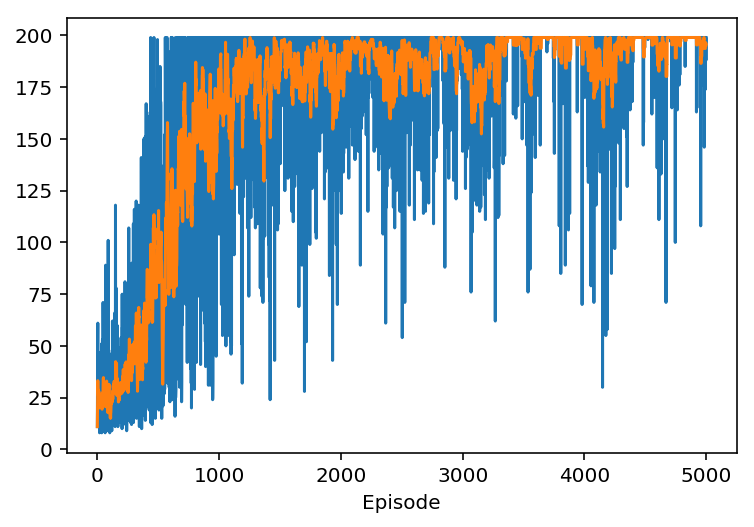

In [7]:
net, rewards = main()

In [2]:
max_steps = 10000
episodes = 100
env = gym.make('CartPole-v0')

for episode in range(episodes):
    state = env.reset()
    for steps in range(max_steps):
        env.render()
        action = env.action_space.sample()
        #action, log_prob = net.get_action(state)
        new_state, reward, done, _ = env.step(action)
        #log_probs.append(log_prob)
        #rewards.append(reward)
        if done:
            print('Done')
            break
        
env.close()


True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Done


In [11]:
env.close()

In [6]:
import numpy as np

In [7]:
gamma = .9

def discount_rewards(rewards):
    discounted_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(0, len(rewards))):
        if rewards[t] != 0:
            running_add = 0
        running_add = running_add * gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards

In [10]:
rewards = [10, 1, 1, 10, 10, 1, 10, 100]
discount_rewards(np.vstack(rewards))


array([[ 10],
       [  1],
       [  1],
       [ 10],
       [ 10],
       [  1],
       [ 10],
       [100]])

In [11]:
np.squeeze(np.vstack(rewards))


array([ 10,   1,   1,  10,  10,   1,  10, 100])

In [13]:
import sys
from termcolor import colored, cprint

text = colored('Hello, World!', 'red', attrs=['reverse', 'blink'])
print(text)
cprint('Hello, World!', 'green', 'on_red')

print_red_on_cyan = lambda x: cprint(x, 'red', 'on_cyan')
print_red_on_cyan('Hello, World!')
print_red_on_cyan('Hello, Universe!')

for i in range(10):
    cprint(i, 'magenta', end=' ')

cprint("Attention!", 'red', attrs=['bold'], file=sys.stderr)

Hello, World!
Hello, World!
Hello, World!
Hello, Universe!
0 1 2 3 4 5 6 7 8 9 

Attention!


In [28]:
text = colored('Samy va a lecole', 'blue', 'on_red', attrs=['reverse', 'bold'])
print(text)

Samy va a lecole


In [31]:
cprint('Samy va a lecole', 'blue', attrs=[ 'bold'], file=sys.stderr)

Samy va a lecole


In [26]:
actions = ['Forward', 'Left', 'Left', 'Right', 'Forward', 'Forward', 'Right']

text = ' > '.join([colored(act, 'cyan', attrs=['bold']) if act == 'Forward' else colored(act, 'magenta', attrs=['bold']) if act == 'Left' else colored(act, 'yellow', attrs=['bold']) for act in actions])
print(text)



Forward > Left > Left > Right > Forward > Forward > Right


In [32]:
left_aligned = "Left Align"
center = "Centered"
right_aligned = "Right Align"
"{left_aligned:<15}{center:^10}{right_aligned:>15}".format(left_aligned=left_aligned, center=center, right_aligned=right_aligned)


'Left Align      Centered     Right Align'

In [38]:
left_aligned = "Left"
center = "Centered"
right_aligned = "Right"
"{left_aligned:<15}{center:^10}{right_aligned:>8}".format(left_aligned=left_aligned, center=center, right_aligned=right_aligned)



'Left            Centered    Right'

In [37]:
'Left            Centered    Right'
len('Left            Centered           Right')

40

In [72]:
actions = ['Left', 'Right', 'Right', 'Forward', 'Left', 'Left', 'Forward', 'Right', 'Right', 'Left', 'Left', 'Right', 'Forward', 'Right', 'Right', 'Forward', 'Left', 'Left']
linked_actions = ' > '.join(actions)
linked_actions = textwrap.wrap(linked_actions)
linked_actions = [(13* ' ') + line if ix > 0 else line for ix,line in enumerate(linked_actions)]
text = colored('Actions    :', 'green', attrs=['reverse','bold']) + ' ' + '\n'.join(linked_actions)
print(text)





Actions    : Left > Right > Right > Forward > Left > Left > Forward > Right > Right
             > Left > Left > Right > Forward > Right > Right > Forward > Left >
             Left


In [45]:
linked_actions

'Left > Right > Right > Forward > Left > Left > Forward > Right > Right > Left > Left > Right > Forward > Right > Right > Forward > Left > Left'

In [46]:
import textwrap

text = "Come and see the violence inherent in the system. Help! Help! I'm being repressed! Listen, strange women lyin' in ponds distributin' swords is no basis for a system of government. Supreme executive power derives from a mandate from the masses, not from some farcical aquatic ceremony. The Lady of the Lake, her arm clad in the purest shimmering samite held aloft Excalibur from the bosom of the water, signifying by divine providence that I, Arthur, was to carry Excalibur. THAT is why I am your king."    

wrapped_text = textwrap.wrap(text)
for line in wrapped_text:
    print(line.center(80))

       Come and see the violence inherent in the system. Help! Help! I'm        
       being repressed! Listen, strange women lyin' in ponds distributin'       
     swords is no basis for a system of government. Supreme executive power     
     derives from a mandate from the masses, not from some farcical aquatic     
     ceremony. The Lady of the Lake, her arm clad in the purest shimmering      
     samite held aloft Excalibur from the bosom of the water, signifying by     
     divine providence that I, Arthur, was to carry Excalibur. THAT is why      
                                I am your king.                                 


In [70]:
t = textwrap.wrap(linked_actions)
t = [(10* ' ') + line if ix > 0 else line for ix,line in enumerate(t)]
print('\n'.join(t))

Left > Right > Right > Forward > Left > Left > Forward > Right > Right
          > Left > Left > Right > Forward > Right > Right > Forward > Left >
          Left


In [53]:
import string
def reindent(s, numSpaces):
    s = str.split(s, '\n')
    s = [(numSpaces * ' ') + str.lstrip(line) for line in s]
    s = '\n'.join(s)
    return s

In [54]:
reindent(linked_actions, 8)

'        Left > Right > Right > Forward > Left > Left > Forward > Right > Right > Left > Left > Right > Forward > Right > Right > Forward > Left > Left'